<a href="https://colab.research.google.com/github/allansdefreitas/unsupervised-learning/blob/main/questao_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
"""Read:
https://sites.google.com/site/dataclusteringalgorithms/fuzzy-c-means-clustering-algorithm
https://towardsdatascience.com/fuzzy-c-means-clustering-with-python-f4908c714081
https://github.com/theimageprocessingguy/Fuzzy-C-Means-Python


https://pyclustering.github.io/docs/0.10.1/html/
https://scikit-fuzzy.github.io/scikit-fuzzy/
https://www.youtube.com/watch?v=nGWmgHxIoPk&ab_channel=%E6%9D%8E%E6%94%BF%E8%BB%92
https://www.youtube.com/watch?v=zEYxTGDYWYI

"""

'Read:\nhttps://sites.google.com/site/dataclusteringalgorithms/fuzzy-c-means-clustering-algorithm\nhttps://towardsdatascience.com/fuzzy-c-means-clustering-with-python-f4908c714081\nhttps://github.com/theimageprocessingguy/Fuzzy-C-Means-Python\n\n\nhttps://pyclustering.github.io/docs/0.10.1/html/\nhttps://scikit-fuzzy.github.io/scikit-fuzzy/\nhttps://www.youtube.com/watch?v=nGWmgHxIoPk&ab_channel=%E6%9D%8E%E6%94%BF%E8%BB%92\nhttps://www.youtube.com/watch?v=zEYxTGDYWYI\n\n'

In [80]:
!pip install scikit-fuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [107]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from numpy import savetxt
from numpy import loadtxt
from sklearn.metrics import adjusted_rand_score
from sklearn import metrics
from sklearn import preprocessing
import skfuzzy as fuzz
from scipy.spatial.distance import cdist
from sklearn.metrics import f1_score

In [82]:
def initialize_membership_matrix(n_samples, n_clusters):
    """
    Initializes the membership matrix for Fuzzy C-Means.

    Parameters:
        n_samples (int): Number of data points.
        n_clusters (int): Number of clusters.

    Returns:
        numpy.ndarray: Initial membership matrix.
    """
    membership_matrix = np.random.rand(n_samples, n_clusters)
    membership_matrix /= np.sum(membership_matrix, axis=1, keepdims=True)
    return membership_matrix


def update_membership_matrix(data, centroids, m, distance_metric):
    """
    Updates the membership matrix for Fuzzy C-Means.

    Parameters:
        data (numpy.ndarray): Input data points.
        centroids (numpy.ndarray): Current centroid positions.
        m (float): Fuzziness parameter.
        distance_metric (str): Distance metric to use ('cityblock' or 'euclidean').

    Returns:
        numpy.ndarray: Updated membership matrix.
    """
    n_samples, n_clusters = data.shape[0], centroids.shape[0]
    membership_matrix = np.zeros((n_samples, n_clusters))

    for i in range(n_samples):
        for j in range(n_clusters):
            if distance_metric == 'cityblock':
                dist = np.sum(np.abs(data[i] - centroids[j]))
            elif distance_metric == 'euclidean':
                dist = np.linalg.norm(data[i] - centroids[j])
            else:
                raise ValueError("Invalid distance metric.")

            membership_matrix[i, j] = 1 / np.sum((dist / np.abs(data[i] - centroids)) ** (2 / (m - 1)))

    membership_matrix /= np.sum(membership_matrix, axis=1, keepdims=True)
    return membership_matrix


def update_centroids(data, membership_matrix, m):
    """
    Updates the centroids for Fuzzy C-Means.

    Parameters:
        data (numpy.ndarray): Input data points.
        membership_matrix (numpy.ndarray): Current membership matrix.
        m (float): Fuzziness parameter.

    Returns:
        numpy.ndarray: Updated centroid positions.
    """
    n_clusters, n_features = membership_matrix.shape[1], data.shape[1]
    centroids = np.zeros((n_clusters, n_features))

    for j in range(n_clusters):
        membership_power = membership_matrix[:, j] ** m
        centroids[j] = np.sum(membership_power.reshape(-1, 1) * data, axis=0) / np.sum(membership_power)

    return centroids



def fuzzy_cmeans(data, n_clusters_C, m, error_e=1e-6, max_iter=100, tolerance=1e-4, distance_metric='cityblock'):
    
    """
    Fuzzy C-Means clustering algorithm.

    Parameters:
        data (numpy.ndarray): Input data points.
        n_clusters (int): Number of clusters.
        m (float): Fuzziness parameter (> 1).
        distance_metric (str): Distance metric to use ('cityblock' or 'euclidean').
        max_iter (int): Maximum number of iterations.
        error_e (float): Convergence tolerance.

    Returns:
        numpy.ndarray: Final centroid positions.
        numpy.ndarray: Membership matrix.
        int: Number of iterations performed.
    """
    n_samples, n_features = data.shape
    membership_matrix = initialize_membership_matrix(n_samples, n_clusters_C)
    centroids = np.zeros((n_clusters_C, n_features))

    for iteration in range(max_iter):
        prev_centroids = centroids.copy()

        centroids = update_centroids(data, membership_matrix, m)
        membership_matrix = update_membership_matrix(data, centroids, m, distance_metric)

        if np.linalg.norm(centroids - prev_centroids) < error_e:
            break

    #transpose the U membership matrix 
    return centroids, membership_matrix.T, iteration+1

In [83]:
def preprocess_dataset(dataframe):

    #pre-processing of dataset
    scaler = StandardScaler()
    data = scaler.fit_transform(dataframe.values)
    
    return data

#VERIFY
def calculate_objective(data, centroids, membership_matrix, m, distance_metric='cityblock'):
    """
    Calculates the objective function value for Fuzzy C-Means.

    Parameters:
        data (numpy.ndarray): Input data points.
        centroids (numpy.ndarray): Current centroid positions.
        membership_matrix (numpy.ndarray): Current membership matrix.
        m (float): Fuzziness parameter.
        distance_metric (str): Distance metric to use ('cityblock' or 'euclidean').

    Returns:
        float: Objective function value.
    """

    data = data.T
    centroids = centroids.T
    membership_matrix = membership_matrix.T
    
    objective = 0
    n_samples, n_clusters = data.shape[0], centroids.shape[0]
    #É preciso obter a matriz transposta, já que aqui temos matriz de shape (num_grupos, num_elementos)
    #e o método espera o oposto disso. 
    membership_matrix = membership_matrix
    print(membership_matrix.shape)
    
    for i in range(n_samples):
        for j in range(n_clusters):
            if distance_metric == 'cityblock':
                #print(data[i].shape)
                #print("\ncent:")
                #print(centroids[j].shape)

                dist = np.sum(np.abs(data[i] - centroids[j]))

            objective += (membership_matrix[i, j] ** m) * (dist ** 2)

    return objective

#Modified partition coefficient e partition entropy --------------################


#close to 1 values are better
#A value of 0 indicates complete fuzziness, where data points have equal membership to all clusters
#A value of 1 indicates crisp or hard clustering, where data points have membership to only one cluster.
#VERIFY
def calculate_mpc(membership_matrix):
    """
    Apply T operation over the U matrix before later operations.
    Calculates the Modified Partition Coefficient (MPC) for Fuzzy C-Means clustering.

    Parameters:
        membership_matrix (numpy.ndarray): Membership matrix of shape (n_samples, n_clusters).

    Returns:
        float: Modified Partition Coefficient value.

    """
    membership_matrix = membership_matrix.T #after we will have  (n_clusters, n_samples).

    max_memberships = np.max(membership_matrix, axis=1) 
    sum_memberships = np.sum(membership_matrix, axis=1)

    mpc = np.mean(max_memberships / sum_memberships)

    return mpc

#close to 0 values are better
#A value of 0 indicates a crisp or hard clustering, where data points have membership only to one cluster and there is no uncertainty
#higher values indicates uncertainty and fuzziness in the clustering, with data points having more equal memberships across multiple clusters.
#VERIFY
def calculate_partition_entropy(membership_matrix):
    """
    Apply T operation over the U matrix before later operations.
    Calculates the Partition Entropy for Fuzzy C-Means clustering.

    Parameters:
        membership_matrix (numpy.ndarray): Membership matrix of shape (n_samples, n_clusters).

    Returns:
        float: Partition Entropy value.
    """
    membership_matrix = membership_matrix.T #after we will have  (n_clusters, n_samples).
    n_samples, n_clusters = membership_matrix.shape

    entropy = 0.0

    for i in range(n_samples):
        for j in range(n_clusters):
            if membership_matrix[i, j] > 0:
                entropy -= membership_matrix[i, j] * np.log2(membership_matrix[i, j])

    partition_entropy = entropy / n_samples

    return partition_entropy


"""## Em cada dataset execute o algoritmo FCM com a distância de City-Block 50 vezes para obter 
uma partição fuzzy em 7 grupos e selecione o melhor resultado segundo a função objetivo."""
def get_best_partition(data, n_clusters_C, m, error_e, maxiter_T, distance_metric = 'cityblock', times_to_run=50):
    
    best_objective_value = 99999999999.9
    best_results = 0
    TIMES = times_to_run
    
    for i in range(TIMES):
    
      # Example usage
      #print("FCM: ", i + 1)
    
      #centroids, membership_matrix, iterations = fuzzy_cmeans(data, n_clusters, m, distance_metric)
      
      cntr, u, u0, d, jm, p, fpc = skfuzzy_fcm(data, n_clusters_C, m, error_e, maxiter_T, distance_metric)
      
      centroids, membership_matrix_U, iterations, objective_functions = cntr, u, p, jm
     
      objective_value = jm[-1] #the last element is the last and best objective function
      
      if(objective_value < best_objective_value):

        best_objective_value = objective_value
      
        best_results = centroids, membership_matrix_U, iterations, best_objective_value
    
    return best_results

#ok
def fuzzy_to_crisp_partition(membership_matrix):
    """
    Converts a fuzzy partition into a crisp partition to be 
    in a one-hot-enconding format.

    Parameters:
        membership_matrix (numpy.ndarray): Membership matrix of shape (n_clusters, n_samples).

    Returns:
        numpy.ndarray: CRISP/hard partition of shape (n_clusters, n_samples).
    """

    U_crisp_matrix = np.zeros_like(membership_matrix)

    labels_for_crisp = np.argmax(membership_matrix, axis=0)

    num_elements = membership_matrix.shape[1] #the number of elements of data

    for i in range(num_elements):
      label_one_hot = labels_for_crisp[i] #position of cluster that will be activated in one-hot-encoding
      U_crisp_matrix[label_one_hot][i] = 1


    return U_crisp_matrix



def get_labels_from_crisp_or_fuzzy(U_matrix):

  """
  Given U crisp or fuzzy matrix, returns the labels
  """

  labels = np.argmax(U_matrix, axis=0)

  return labels

def pie_plot_crisp_partition(U_crisp_matrix, label_names, filename):
  """

  create, show and save a pie plot chart based on crisp matrix and its
  cluster's labels passed as argument of function

  """

  labels_crisp = get_labels_from_crisp_or_fuzzy(U_crisp_matrix)

  #get the quantity/size of ocurrences of each cluster
  _, sizes = np.unique(labels_crisp, return_counts=True)

  fig, ax = plt.subplots()
  ax.pie(sizes, labels=label_names)

  complete_filename = filename + '.png'
  plt.savefig(complete_filename)

#from [-1, 1]. -1 better
#VERIFY
def calculate_ari(clustering_1, clustering_2):

  # Calculate ARI
  ari = adjusted_rand_score(clustering_1, clustering_2)

  return ari

#from [0,1]. 1 is better
#VERIFY
def calculate_f_measureOLD(partition1, partition2):
    tp = sum(1 for i in partition1 for j in partition2 if i == j)  # Conta os verdadeiros positivos
    fp = len(partition1) - tp  # Calcula os falsos positivos
    fn = len(partition2) - tp  # Calcula os falsos negativos

    f_measure = (2 * tp) / (2 * tp + fp + fn)
    return f_measure

def calculate_f_measure(partition1, partition2):

    f_measure = f1_score(partition1, partition2, average='micro')
    return f_measure 

#from:
#https://pythonhosted.org/scikit-fuzzy/api/skfuzzy.cluster.html
def skfuzzy_fcm(data, n_clusters_C, m,  error_e=0.000001, maxiter_T=100, distance_metric='cityblock'):

  #É preciso obter a matriz transposta, já que o método espera uma
  #matriz de shape (S, N), i.e. (num_grupos, num_elementos)
  # print(data.shape)
  data = data.T
  # print(data.shape)
  #data_city_block = cdist(data, data, metric='euclidean') #cityblock, euclidean, cosine #IS THIS RIGHT?
  #print(data_city_block, data_city_block.shape)

  # Perform Fuzzy C-means clustering
  cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
      data, #IT WAS: data_city_block.T. Is this right?  
      n_clusters_C,
      m=m,
      error=error_e,
      maxiter=maxiter_T
  )

  # The 'u' matrix contains the fuzzy membership values for each data point
  return  cntr, u, u0, d, jm, p, fpc

In [84]:
"""
I. Considere os dados "Image Segmentation" do site uci machine learning
repository (https://archive.ics.uci.edu/ml/datasets/Image+Segmentation).

"""

NUMBER_OF_DATASETS = 3

PATH = 'https://raw.githubusercontent.com/allansdefreitas/unsupervised-learning/main/segmentation.data'
PATH2 = 'https://raw.githubusercontent.com/allansdefreitas/unsupervised-learning/main/segmentation.test'

dataset_original = pd.read_csv(PATH, sep=',')
dataset_original2 = pd.read_csv(PATH2, sep=',')

#concat datasets
frames = [dataset_original, dataset_original2]
dataset_original_indexes = pd.concat(frames)

dataset_original = dataset_original_indexes.reset_index(drop=True)

indexes = dataset_original_indexes.index

#obter os labels a priori
indexes = dataset_original_indexes.index
indexes_label = []

for i in indexes:
    indexes_label.append(i)

le = preprocessing.LabelEncoder()
labels_a_priori = le.fit_transform(indexes_label)

labels_clusters_names = '0', '1', '2', '3', '4', '5', '6'

""" Considere 3 datasets: """
""" 1) primeiro considerando as variáveis 4 a 9 (shape) ----------"""

dataset_1 = dataset_original.iloc[:,3:9]
#pre-processing of dataset
X_dataset_1 = preprocess_dataset(dataset_1)


"""2) o segundo considerando as variaveis 10 a 19 (rgb) ----------"""
dataset_2 = dataset_original.iloc[:,9:19]
#pre-processing of dataset
X_dataset_2 = preprocess_dataset(dataset_2)

"""3) O terceiro considerando as variaveis 4 a 19 (shape + rgb) -------"""
dataset_3 = dataset_original.iloc[:,3:19]
#pre-processing of dataset
X_dataset_3 = preprocess_dataset(dataset_3)


""" Em cada dataset execute o algoritmo FCM com a distância de City-Block
50 vezes para obter uma partição fuzzy em 7 grupos e selecione o melhor
resultado segundo a função objetivo. """

' Em cada dataset execute o algoritmo FCM com a distância de City-Block\n50 vezes para obter uma partição fuzzy em 7 grupos e selecione o melhor\nresultado segundo a função objetivo. '

test pyclustering

In [85]:
labels_a_priori, np.unique(labels_a_priori)

(array([0, 0, 0, ..., 1, 1, 1]), array([0, 1, 2, 3, 4, 5, 6]))

In [86]:
#data = X_dataset_1
n_clusters_C = 7
m = 1.1 #{1.1; 1.6; 2.0}. 1.1 resuls on error: RuntimeWarning: overflow encountered in exp AND invalid value encountered in true_divide. USE OTHER IMPL OF FCM
error_e = 0.000001
maxiter_T = 100
distance_metric = 'cityblock'
best_objective_value = 99999999999.9
best_results = 0
times = 1 #50


datasets = [X_dataset_1, X_dataset_2, X_dataset_3]
best_results = []

for dataset_i in datasets:
  #print(dataset_i)
  #print(dataset_i.shape)
  
  #centroids, U, iter = get_best_partition(dataset_i, n_clusters, m, distance_metric = 'cityblock', times_to_run=times)
  centroids, U, iter, objective_value = get_best_partition(dataset_i, n_clusters_C, m, error_e, maxiter_T, distance_metric = 'cityblock', times_to_run=times)
  best_results.append([centroids, U, iter, objective_value])
  
  # print(U)
  #print("\n\n\n", U.shape, "\n\n\n")

#Salvar melhores matrizes de grau de associação (U) e centroids como arquivos csv

#save datasets to csv files ---------------------##
#get the centroids, too?
for i in range(NUMBER_OF_DATASETS):
  membership_matrix_U = best_results[i][1] #i-th membership_matrix
  centroids_matrix = best_results[i][0] #i-th centroids matrix

  # save i-th dataset to csv file
  filename = 'dataset_'+ str(i + 1) + '_U_matrix'
  savetxt(filename + '.csv', membership_matrix_U, delimiter=',')

  # save i-th centroids to csv file
  filename = 'dataset_'+ str(i + 1) + '_centroids_matrix'
  savetxt(filename + '.csv', centroids_matrix, delimiter=',')

#load datasets from csv files --------------------##
membership_matrixes = []
centroids_matrixes = []

for i in range(NUMBER_OF_DATASETS):

  # get i-th dataset U matrix from csv file
  filename = 'dataset_'+ str(i + 1) + '_U_matrix'
  ith_membership_matrix = loadtxt(filename + '.csv', delimiter=',') #recover #i-th membership_matrix
  membership_matrixes.append(ith_membership_matrix)

  # get i-th dataset centroids from csv file
  filename = 'dataset_'+ str(i + 1) + '_centroids_matrix'
  ith_centroids_matrix = loadtxt(filename + '.csv', delimiter=',') #recover #i-th membership_matrix
  centroids_matrixes.append(ith_centroids_matrix)

In [87]:
type(datasets), len(datasets), type(datasets[0]), datasets[0].shape

(list, 3, numpy.ndarray, (2310, 6))

In [88]:
type(membership_matrixes), len(membership_matrixes), membership_matrixes[0].shape

(list, 3, (7, 2310))

In [89]:
membership_matrixes[2].shape

(7, 2310)

In [90]:
centroids_matrixes[0]

array([[-0.02521608,  4.88003112,  0.47700721,  0.07952637,  0.60401383,
         0.04752427],
       [ 2.61639457, -0.19447997, -0.07070653, -0.09247805, -0.07086049,
        -0.10678728],
       [-0.3570445 , -0.19442225,  0.5256126 , -0.03105011,  0.21785901,
        -0.05677478],
       [-0.35642939, -0.18201289,  0.26958651,  0.01948791,  2.77185293,
         0.89269761],
       [-0.35704685, -0.19453566, -0.35782604, -0.11233293, -0.35916318,
        -0.12543032],
       [-0.35704732,  2.76558457,  7.67792055, 12.3690744 ,  7.35582616,
        10.94402134],
       [-0.35704724,  1.14101048,  5.81825989,  2.0516971 ,  2.48869345,
         1.10765941]])

In [92]:
#axis=0. running VERTICALLY downwards across rows (axis 0). OPERA (sum, max..) NA COLUNA, PERCORRENDO AS LINHAS
#axis=1. running HORIZONTALLY across columns (axis 1). OPERA (sum, max..) NA LINHA, PERCORRENDO AS COLUNAS

In [93]:
#fim testes

In [94]:
"""Para cada dataset e partição fuzzy, calcule o Modified partition coefficient
e o Partition entropy. (OK. verificar) Comente"""

#Obtendo Modified partition coefficient e partition entropy para cada dataset

mpc_and_partition_entropies = []

for i in range(NUMBER_OF_DATASETS):

  ith_mem_matrix = membership_matrixes[i]

  mpc = calculate_mpc(ith_mem_matrix)
  partition_entropy = calculate_partition_entropy(ith_mem_matrix)
  MPC_PE_arr = np.array([mpc, partition_entropy])

  # save i-th MPC and PE to csv file
  filename = 'dataset_'+ str(i + 1) + '_MPC_and_PE'
  savetxt(filename + '.csv', MPC_PE_arr, delimiter=',')

  mpc_and_partition_entropies.append( [mpc, partition_entropy] )

In [95]:
mpc_and_partition_entropies #It is CORRECT have values above 1 as partition entropy???

[[0.9902158066988137, 0.035441998885133275],
 [0.9875836051900911, 0.04468783969414812],
 [0.9751809554096478, 0.09204186620182882]]

In [96]:
""" Para cada dataset e partição fuzzy, produza uma partição CRISP em 7
grupos e calcule o índice de Rand corrigido, e a F-measure (adaptada
para agrupamento). Comente """

#obtendo partiçoes CRISP
crisp_partitions = []

for i in range(NUMBER_OF_DATASETS):

  crisp = fuzzy_to_crisp_partition(membership_matrixes[i])

  filename = 'dataset_'+ str(i + 1) + '_CRISP'
  savetxt(filename + '.csv', crisp, delimiter=',')

  crisp_partitions.append(crisp)

crisp_partitions

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 1., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 1., 1., 1.]]),
 array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 1., 1., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])]

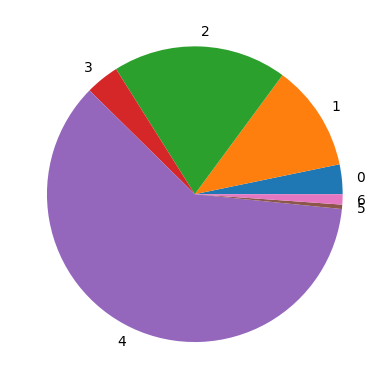

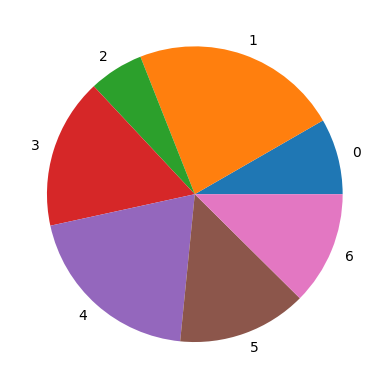

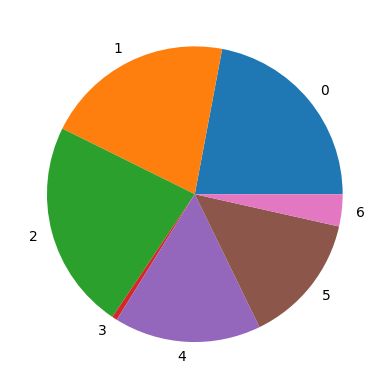

In [97]:
label_names = labels_clusters_names

for i in range(NUMBER_OF_DATASETS):
  
  filename = 'dataset_'+ str(i + 1) + '_CRISP_pie_chart'
  ith_crisp_partition = crisp_partitions[i]
  pie_plot_crisp_partition(ith_crisp_partition, label_names, filename)

In [98]:
get_labels_from_crisp_or_fuzzy

<function __main__.get_labels_from_crisp_or_fuzzy(U_matrix)>

In [111]:
"""Para cada dataset e partição fuzzy, calcule o índice de Rand corrigido, 
e a F-measure (adaptada para agrupamento). Comente"""

#Obtendo Índice de range corrigido e f-measure para cada partição CRISP

rand_index_f_measures = []

for i in range(NUMBER_OF_DATASETS):

  ith_crisp_partition = crisp_partitions[i]
  #get the current labels obtained by clustering
  labels_posteriori = get_labels_from_crisp_or_fuzzy(ith_crisp_partition)

  #put it together with the true labels (labels_a_priori) to calculate the ARI
  clustering_rand_index = calculate_ari(labels_posteriori, labels_a_priori)

  f_measure = calculate_f_measure(labels_posteriori, labels_a_priori)

  # save i-th ARI and F-measure to csv file
  ARI_f_measure = np.array([clustering_rand_index, f_measure])
  
  filename = 'dataset_'+ str(i + 1) + '_ ARI_and_f_measure'
  savetxt(filename + '.csv', ARI_f_measure, delimiter=',')
   
  rand_index_f_measures.append( [clustering_rand_index, f_measure] )

In [112]:
rand_index_f_measures

[[0.05015954740946404, 0.06623376623376623],
 [0.4481441702487652, 0.20562770562770563],
 [0.4567399903678374, 0.41601731601731595]]

In [ ]:
np.unique(crisp)

#entender via video aula etc sobre a aplicação do indice de rand corrigido e f-measure

In [ ]:
#data = X_dataset_1
n_clusters_C = 7
m = 2 #{1.1; 1.6; 2.0}. 1.1 resuls on error: RuntimeWarning: overflow encountered in exp AND invalid value encountered in true_divide. USE OTHER IMPL OF FCM
distance_metric = 'cityblock'
error_e=0.000001
maxiter_T=100
best_objective_value = 99999999999.9
best_results = 0
times = 1 #50



datasets = [X_dataset_1, X_dataset_2, X_dataset_3]

In [ ]:
# centroids, U, iter = fuzzy_cmeans(X_dataset_1, n_clusters_C, m, distance_metric = 'cityblock')

cntr, u, u0, d, jm, p, fpc = skfuzzy_fcm(X_dataset_1.T, n_clusters_C, m, error_e, maxiter_T, distance_metric)
centroids2, U, iter2, objective_functions = cntr, u, p, jm
U

In [ ]:
U[:,0], U.shape

In [ ]:
#verificando validade do cálculo. OK
C = 7
sum = 0
for i in range(C):

  sum += U[i][0]

sum

In [ ]:
preds = U.argmax(axis=0)
preds

In [ ]:
np.unique(preds)

In [ ]:
#https://www.youtube.com/watch?v=zEYxTGDYWYI
#MORE ON: https://scikit-fuzzy.readthedocs.io/en/latest/auto_examples/plot_cmeans.html

In [ ]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

# Define three cluster centers
centers = [[4, 2],
           [1, 7],
           [5, 6]]

# Define three cluster sigmas in x and y, respectively
sigmas = [[0.8, 0.3],
          [0.3, 0.5],
          [1.1, 0.7]]

# Generate test data
np.random.seed(42)  # Set seed for reproducibility
xpts = np.zeros(1)
ypts = np.zeros(1)
labels = np.zeros(1)
for i, ((xmu, ymu), (xsigma, ysigma)) in enumerate(zip(centers, sigmas)):
    xpts = np.hstack((xpts, np.random.standard_normal(200) * xsigma + xmu))
    ypts = np.hstack((ypts, np.random.standard_normal(200) * ysigma + ymu))
    labels = np.hstack((labels, np.ones(200) * i))

# Visualize the test data
fig0, ax0 = plt.subplots()
for label in range(3):
    ax0.plot(xpts[labels == label], ypts[labels == label], '.',
             color=colors[label])
ax0.set_title('Test data: 200 points x3 clusters.')

In [ ]:
alldata.shape

In [ ]:
# Set up the loop and plot
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
alldata = np.vstack((xpts, ypts))
fpcs = []

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(xpts[cluster_membership == j],
                ypts[cluster_membership == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')

fig1.tight_layout()

In [ ]:
#objective_value = calculate_objective(X_dataset_1, centroids, U, m, distance_metric)
objective_value = calculate_objective(X_dataset_1.T, centroids, U, m, distance_metric)
objective_value

In [ ]:
X_dataset_1.T.shape

In [ ]:
import numpy as np
import skfuzzy as fuzz
from scipy.spatial.distance import cdist

# Generate some random data
#data = np.random.rand(100, 2)

# Set the number of clusters
num_clusters = 3

# Apply city-block (Manhattan) distance effect
data_city_block = cdist(data, data, metric='cityblock') #euclidean, cosine

# Perform Fuzzy C-means clustering
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    data_city_block.T,
    num_clusters,
    2,
    error=0.005,
    maxiter=1000
)

# The 'u' matrix contains the fuzzy membership values for each data point

# Print the cluster centers
print("Cluster centers:")
print(cntr)

# Print the fuzzy membership values for the first data point
print("Fuzzy membership values for data point 0:")
print(u[:, 0])


In [ ]:

import numpy as np
import skfuzzy as fuzz
from scipy.spatial.distance import cdist

# Set the random seed for reproducibility
RANDOM_SEED=42

np.random.seed(RANDOM_SEED)

# Generate some random data
data = np.random.rand(100, 2)

# Set the number of clusters
num_clusters = 3

# Apply city-block (Manhattan) distance effect
data_city_block = cdist(data, data, metric='cityblock') #cityblock, euclidean, cosine

# Set the random seed for numpy.random
np.random.seed(RANDOM_SEED)

# Perform Fuzzy C-means clustering
# cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data_city_block.T,
    num_clusters,
    m=2,
    error=0.005,
    maxiter=1000
)

# The 'u' matrix contains the fuzzy membership values for each data point

return_func = cntr, u, p

# Print the cluster centers
print("Cluster centers:")
print(cntr)

# Print the fuzzy membership values for the first data point
print("Fuzzy membership values for data point 0:")
print(u[:, 0])



In [ ]:
u.shape 

In [ ]:
u

In [ ]:
u_T = u.T
u_T.shape

In [ ]:
u_T

In [ ]:
u_T[0][0] + u_T[0][1] + u_T[0][2] 

In [ ]:
#https://pyclustering.github.io/docs/0.10.1/html/d2/d6a/classpyclustering_1_1cluster_1_1fcm_1_1fcm.html

In [ ]:
!pip3 install pyclustering

In [ ]:
from pyclustering.samples.definitions import FAMOUS_SAMPLES
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.fcm import fcm
from pyclustering.utils import read_sample
 
# load list of points for cluster analysis
#sample = read_sample(FAMOUS_SAMPLES.SAMPLE_OLD_FAITHFUL)
sample = X_dataset_1
# initialize
initial_centers = kmeans_plusplus_initializer(sample, 7, kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE).initialize()
 
# create instance of Fuzzy C-Means algorithm
fcm_instance = fcm(sample, initial_centers)
 
# run cluster analysis and obtain results
fcm_instance.process()
clusters = fcm_instance.get_clusters()
centers = fcm_instance.get_centers()
 
# visualize clustering results
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, sample)
visualizer.append_cluster(centers, marker='*', markersize=10)
visualizer.show()

In [ ]:
len(clusters), type(clusters), type(clusters[0])

In [ ]:
len(clusters[0])

In [ ]:
len(centers), centers

In [ ]:
#verificar se soma de probabilidades para cada cluster resulta em 1
e = 1
sum = 0
for i in range(n_clusters_C):

  sum += membership_matrixes[0][i][e]

sum